In [53]:
import os
import glob
import cv2
import numpy as np
import random
import hashlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling3D,
                                     Conv3D, MaxPooling3D, BatchNormalization)
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall

In [54]:
# Function to compute video hash (to remove duplicates)
def get_video_hash(video_path, num_frames=16, input_size=(112, 112)):
    cap = cv2.VideoCapture(video_path)
    frame_hashes = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(1, total_frames // num_frames)
    count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            frame = cv2.resize(frame, input_size)
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_bytes = frame_gray.tobytes()
            frame_hashes.append(hashlib.md5(frame_bytes).hexdigest())
        count += 1

    cap.release()
    return tuple(frame_hashes)


In [55]:
# Load dataset and remove duplicates
DATASET_PATH = "Shop_DataSet/"
video_paths, labels = [], []
unique_video_hashes = {}

In [56]:
for label, category in enumerate(["non_shop_lifters", "shop_lifters"]):
    video_folder = os.path.join(DATASET_PATH, category)
    video_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    
    for video_file in video_files:
        video_hash = get_video_hash(video_file)
        if video_hash not in unique_video_hashes:
            unique_video_hashes[video_hash] = video_file
            video_paths.append(video_file)
            labels.append(label)

print(f"Total Unique Videos: {len(video_paths)}")


Total Unique Videos: 637


In [57]:
# Split dataset (80% Train, 20% Test)
train_videos, test_videos, train_labels, test_labels = train_test_split(video_paths, labels, test_size=0.2, random_state=42)

In [58]:
# Video Data Generator Class
class VideoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size=4, num_frames=16, input_size=(112, 112)):
        self.video_paths = np.array(video_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.input_size = input_size
        self.indexes = np.arange(len(self.video_paths))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_video_paths = self.video_paths[batch_indexes]
        batch_labels = self.labels[batch_indexes]
        X, y = self.__data_generation(batch_video_paths, batch_labels)
        return X, y

    def __data_generation(self, batch_video_paths, batch_labels):
        batch_frames = []
        batch_labels_final = []

        for i, video_path in enumerate(batch_video_paths):
            frames = self.video_to_frames(video_path)
            batch_frames.append(frames)
            batch_labels_final.append(batch_labels[i])

        return np.array(batch_frames, dtype=np.float32), np.array(batch_labels_final, dtype=np.float32)

    def video_to_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_interval = max(1, total_frames // self.num_frames)
        
        count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_interval == 0:
                frame = cv2.resize(frame, self.input_size)
                frames.append(frame)
            count += 1

        cap.release()
        frames = np.array(frames, dtype=np.float32) / 255.0  # Normalize
        if len(frames) < self.num_frames:
            pad_size = self.num_frames - len(frames)
            pad_frames = np.zeros((pad_size, *self.input_size, 3), dtype=np.float32)
            frames = np.concatenate((frames, pad_frames), axis=0)

        return frames[:self.num_frames]

# Create Data Generators
train_generator = VideoDataGenerator(train_videos, train_labels, batch_size=4)
val_generator = VideoDataGenerator(val_videos, val_labels, batch_size=4)

In [59]:
# Build I3D Model
input_tensor = Input(shape=(16, 112, 112, 3))
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_tensor)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = BatchNormalization()(x)

x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = BatchNormalization()(x)

x = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling3D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=x)
# Compile Model with Precision and Recall Metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Model Summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 16, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 8, 56, 56, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 56, 56, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 8, 56, 56, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 4, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 28, 28, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 4, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 2, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 2, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,473 (1.20 MB)

 Trainable params: 313,025 (1.19 MB)

 Non-trainable params: 448 (1.75 KB)

In [60]:
# Train Model (WITHOUT CALLBACKS)
history=model.fit(train_generator, epochs=10)

C:\Users\Dodooz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 89s 683ms/step - accuracy: 0.8000 - loss: 0.5035 - precision_1: 0.8381 - recall_1: 0.7412
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 84s 664ms/step - accuracy: 0.8763 - loss: 0.2673 - precision_1: 0.8544 - recall_1: 0.9153
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 84s 666ms/step - accuracy: 0.9227 - loss: 0.1823 - precision_1: 0.9252 - recall_1: 0.9264
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 86s 678ms/step - accuracy: 0.9199 - loss: 0.1759 - precision_1: 0.9018 - recall_1: 0.9443
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 88s 689ms/step - accuracy: 0.9367 - loss: 0.1659 - precision_1: 0.9212 - recall_1: 0.9554
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 87s 683ms/step - accuracy: 0.9458 - loss: 0.1475 - precision_1: 0.9572 - recall_1: 0.9448
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 87s 681ms/step - accuracy: 0.9466 - loss: 0.1325 - precision_1: 0.9666 - recall_1: 0.9321
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 88s 694ms/step - accuracy: 0.9668 - loss: 0.1034 -

In [62]:
# Save Model
model.save("i3d_model.h5")

In [63]:
# Load trained model
model = tf.keras.models.load_model("i3d_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


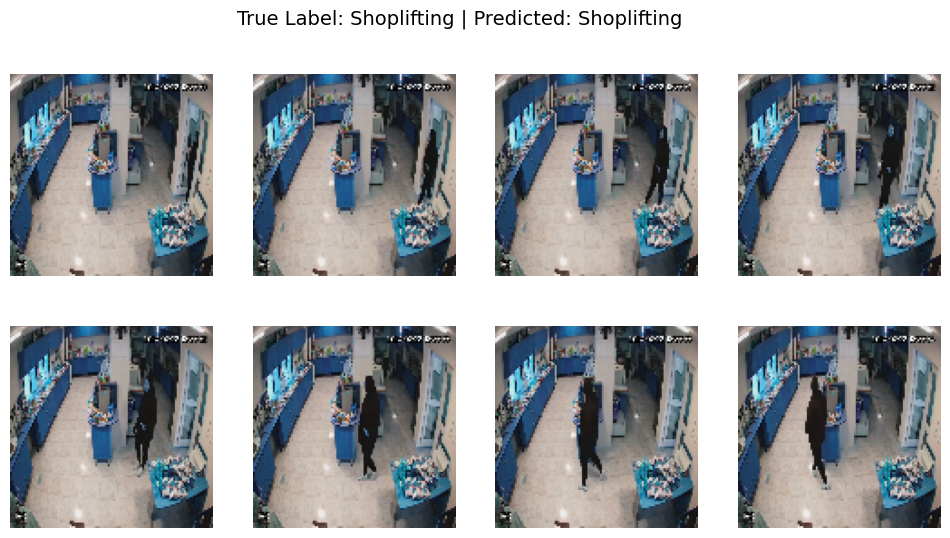

In [76]:
import random

# Select a random video from the test set
random_index = random.randint(0, len(test_videos) - 1)
random_video_path = test_videos[random_index]
true_label = test_labels[random_index]

# Process the video into frames
video_frames = train_generator.video_to_frames(random_video_path)
video_frames = np.expand_dims(video_frames, axis=0)  # Add batch dimension

# Make prediction
pred = model.predict(video_frames)[0][0]
pred_label = 1 if pred >= 0.5 else 0  # Convert to binary classification

# Display the result
plt.figure(figsize=(12, 6))
for i in range(min(8, video_frames.shape[1])):  # Show up to 8 frames
    plt.subplot(2, 4, i + 1)
    plt.imshow(video_frames[0, i])  # First batch, i-th frame
    plt.axis("off")
plt.suptitle(f"True Label: {'Shoplifting' if true_label == 1 else 'Non-Shoplifting'} | Predicted: {'Shoplifting' if pred_label == 1 else 'Non-Shoplifting'}", fontsize=14)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

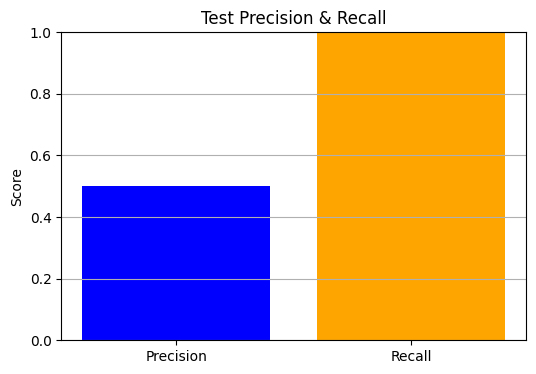

In [64]:
# Evaluate Model on Test Set
test_precision = tf.keras.metrics.Precision()
test_recall = tf.keras.metrics.Recall()

for i in range(len(test_videos)):  
    test_video = train_generator.video_to_frames(test_videos[i])
    test_video = np.expand_dims(test_video, axis=0)
    true_label = test_labels[i]

    pred = model.predict(test_video)[0][0]
    pred_label = 1 if pred >= 0.5 else 0  

    test_precision.update_state([true_label], [pred_label])
    test_recall.update_state([true_label], [pred_label])

# Get final precision and recall values
final_precision = test_precision.result().numpy()
final_recall = test_recall.result().numpy()

print(f"Test Precision: {final_precision:.4f}")
print(f"Test Recall: {final_recall:.4f}")

# Visualize test precision and recall
plt.figure(figsize=(6, 4))
plt.bar(['Precision', 'Recall'], [final_precision, final_recall], color=['blue', 'orange'])
plt.title('Test Precision & Recall')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()